# Detecting Faked Redactions
PyMuPDF has ways to detect **fake redactions.** This refers to text that **_appears_** to be deleted and replaced by a black rectangle, whereas in reality the text is still there and is just **covered** by a rectangle.

In such cases, the text could still be extracted and sensitive or confidential information would thus be leaked. For example, in a legal context it is important to know whether sensitive personal information is insufficiently protected.

> Do have a look at the [this](https://github.com/freelawproject/x-ray) project, which makes active use of PyMuPDF features to help detect situations like these.

## The Example Document Page
We will show an example of some legal document, which **_pretends_** to protect sensitive information by black rectangles.

In the course of this notebook we will exhibit, that the sensitive texts is in fact **_not protected_** and can still be extracted.

In [1]:
# uncomment the following line(s) to ensure that all packages are available:
#!python -m pip install matplotlib
#!python -m pip install -U pymupdf

%matplotlib inline
import fitz  # import PyMuPDF

def show_image(pix):
    """Display a pixmap using matplotlib and numpy."""
    import matplotlib.pyplot as plt  # needed for displaying intermediate images
    import numpy as np  # needed for displaying intermediate images
    img = np.ndarray((pix.h, pix.w, 3), dtype=np.uint8, buffer=pix.samples_mv)  # raw image to numpy array
    plt.figure(dpi=150)
    image = plt.imshow(img)  # let matplotlib show the image

Open example PDF and access its first page:

In [2]:
doc = fitz.open("blacked.pdf")
page = doc[0]  # this page contains 3 fake redactions

Display an image of the page to show the situation: There are three black rectangles in the page's upper half, that render text invisible. The question is how to detect whether the original text really is gone and not extractable?

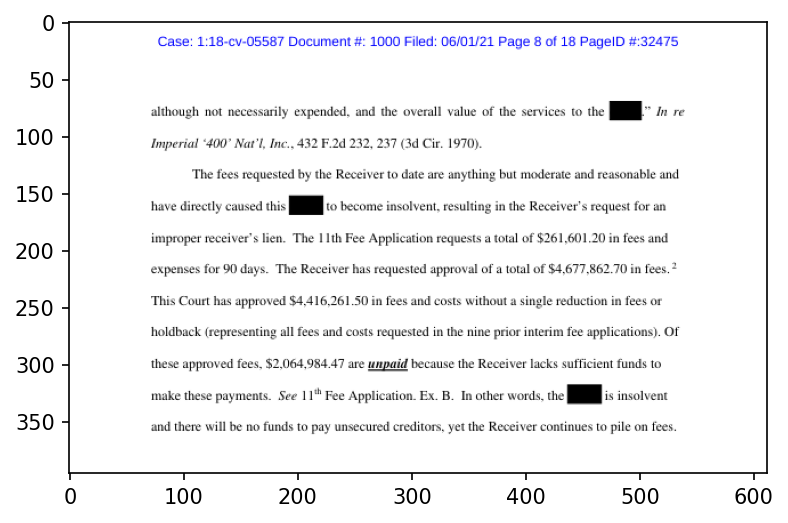

In [3]:
# rectangles are in upper page half, make an illustrative image
clip = page.rect
clip.y1 /= 2
pix = page.get_pixmap(clip=clip)
show_image(pix)

## The Detection Algorithm
We now try to find text that is covered by some black rectangle.

In this context it is important to note that a page's appearance is created by a set of special commands, which are executed sequentially by PDF document viewers.

Having this in mind, we can conclude that text is **_hidden_** if a non-transparent black rectangle is drawn "later", that covers the text area (or some part of it).

These considerations bring us to our detection strategy:
1. Find rectangular vector graphics with fill color black and no transparency.
2. Find text characters positioned in one of these rectangles, that are written **_before_** the rectangle is drawn.

In [4]:
# find black non-transparent rectangles
vector_rects = {}  # stores black rectangles and their writing sequence number
for p in page.get_drawings():  # walk through the vector graphics
    if p["type"] == "s":  # we are interested in paths with a fill color only
        continue
    if p["fill_opacity"] != 1: # must be non-transparent
        continue
    if p["fill"] != (0, 0, 0): # only look at black fill color
        continue
    for item in p["items"]:  # make sure the graphic does contain rectangles
        if not item[0] == "re":
            continue
        rect = item[1]  # the rectangle coordinates
        if rect.width <= 3 or rect.height <= 3:  # omit tiny rectangles
            continue
        vector_rects[rect] = p["seqno"]  # this is a rectangle candidate with its sequence number
print(f"There are {len(vector_rects)} suspicious rectangles.")

There are 3 suspicious rectangles.


We obviously have located the three rectangles shown in the picture above.

Now hunt down any characters that are written earlier (i.e. smaller sequence numbers) and are at least partly covered by some black rectangle.

Let us start with a list of **_all_** characters with their bounding box and the writing sequence number:

In [5]:
# make a list of all characters with their bbox and the writing sequence number
chars = []
for span in page.get_texttrace():  # this method gives us all needed information
    seqno = span["seqno"]  # the writing sequence number of the text piece
    for c, _, o, b in span["chars"]:  # iterate over character items
        ch = chr(c)  # convert unicode to character string
        if not ch.isalnum():  # we are only interested in alphanumeric text
            continue  # no spaces, punctuations etc.
        bbox = fitz.Rect(b)  # convert the delivered tuple to a Rect object
        chars.append((chr(c), bbox, seqno))  # store char info

In the final step we bring together the above two information pieces to produce our result.

In [6]:
for i, r in enumerate(vector_rects.keys()):  # iterate over black rectangles
    # compute a list of characters (partly) covered by r and written earlier
    rseqno = vector_rects[r]  # sequence number of r
    contains = [
        c for c, bbox, seqno in chars if abs(bbox & r) > 0 and seqno < rseqno
    ]
    if contains != []:  # if this rectangle covers any text, show it
        text = "".join(contains)
        print(f"Rectangle {i} hides '{text}'.")

Rectangle 0 hides 'estate'.
Rectangle 1 hides 'Estate'.
Rectangle 2 hides 'Estate'.


# The Detection Result
The above algorithm has correctly uncovered three fake redactions and exhibited the text that was not correctly erased.